# Aplicación: Predecir recesión para Estados Unidos

Un leading indicator es una variables que cambio antes que el resto de la economía.


# I. Introducción

Las variables financieras, como los precios de los instrumentos financieros se asocian con las expectativas con los eventos económicos futuros.

Tasas de interés a largo plazo son frecuentemente analizadas como el promedio ponderando de las expectativas futuras de las tasas de interés a corto plazo.

El *spread* entre tasas de diferentes vencimientos son interpretados como las expectativas de las tasas futuras, correspondiente al periodo entre los vencimientos.

*Stock Prices* son interpretadas como el valor descontado esperado del pago de un dividendo futuro y así se incorpora las vista relacionada con la rentabilidad futura y la tasa de interés de interés futura o tasa de descuento.

Se analizará la utilidad de varias variables financieras en la predicción fuera de la muestra de si la economía de los Estados Unidos caerá en recesión o no entre un trimestre y ocho trimestres en el futuro.

Variables con potencial predictividad:

* Tasa de interés
* Spread de tasa de interés
* Stock price indexes
* Agregados monetarios

Son seleccionados desde una colección amplia de candidatos y son examinados por sí mismos en una combinación plausible.
Estos se van a comparar con los indicadores macroeconómicos tradicionales incluyendo indices de leading indicators ampliamente usados y sus variables componentes.

Dos aspectos de diferencia:
1. Se a enfocar en predecir la recesión en lugar de medir la cantidad de la actividad futura.(Hamilton (1989) Indica que la economía evoluciona de manera diferente dentro de distintos estados discretos.La variable dependiente discreta esquiva el problema de la precisión espúrea asociado con la cantidad de los puntos estimados, por ejemplo, el crecimiento del PIB real.

2. El principal criterio de precisión predictiva es el desempeño  fuera de la muestra, out-of-sample, precisión para los trimestres más allá de los trimestres en el que el modelo es estimado.


Razones para enfoque (simplista)

1. Los indicadores pueden ser usados para un doble check (predicciones econométricas y Judgmental)
   
   * Los policy makers y los market participant se pueden beneficiar al solo considerar ver indicadores financieros bien escogidos.
   * *Judgmental forecasts*, aunque no tiene base estrictamente en el análisis estadístico, involucra pensamiento acerca de *relaciones económicas* al igual que los modelos macroeconométricos, y tienen los mismos beneficios. 
   * Al final, las predicciones finales no son en la mayor parte, lo más interesante del ejercicio del modelado.
   * Una rápida mirada al indicador financiero puede decaer a un problema con los resultado de enfoque dado. Si el modelos y el indicador coincide, la confianza en los resultados del modelo se enfatiza. Si no coincide puede ser valioso revisar los supuestos y las relaciones que dejan las predicciones. La significancia que uno se le puede atribuir a un indicador depende de su desempeño histórico.


2. Evitar el overfitting
   * Generalmente mientras más variables incluye un modelo mejor los resultados.


3. Es rápido y simple
   * El análisis debería determinar qué indicadores particulares son valiosos ver.
   * Provee la probabilidad pronosticada de una recesión futura.

# II. Modelo y Datos

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader.data as web

from sklearn import (
    linear_model, metrics, neural_network, pipeline, preprocessing, model_selection
)

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

1. Interest Rates and Spreads
   * 10-year–3-month Treasury spread
   * Commercial paper–Treasury spread (6 months) -- CPFF
   * 3-month T bill
   * 10-year T bond
2. Stock Prices
   * Dow Jones industrials
   * NYSE composite -- nos falta
   * S&P 500
3. Monetary Aggregates
   * Monetary base
   * M1
   * M2
   * M3
   * Monetary base deﬂated 
   * M1 deﬂated by CPI
   * M2 deﬂated by CPI
   * M3 deﬂated by CPI
4. Individual Macro Indicators
   * Growth in real GDP, previous quarter
   * Consumer price index
   * Purchasing managers’ survey
   * Vendor performance
   * Contracts and orders for plant and equipment
   * Housing permits
   * Consumer expectations (MI)
   * Trade-weighted dollar
   * Change in manufacturers’ unﬁlled durable
   * goods orders
5. Indexes of Leading Indicators
   * Commerce Department leading index
   * Stock–Watson (1989) leading index
   * Stock–Watson (1993) leading index


In [2]:
#!pip install Quandl
quandl_api_key = 'BxS3e9G3WVWppZFUqNQq'
import quandl
mydata = quandl.get("FRED/GDP", start_date="2001-12-31", end_date="2005-12-31")

### Datos 

Agrupamos los datos de FRED.

In [4]:
start = "1982-01-01"
end = datetime.date.today()

In [5]:
def pct_change_on_last_year(df):
    "compute pct_change on previous year, assuming quarterly"
    return (df - df.shift(4))/df.shift(4)

In [28]:
def get_indicators_from_fred(start = start, end = end):
    """
    Fetch quarterly data on 6 leading indicators from time period start:end
    """
    # Interest Rates and Spreads
    interest_rate_spread = (
        web.DataReader(["T10Y3M", "DGS3MO", "DGS10"], "fred", start, end)
        .resample("QS")
        .mean()
    )

    # monetary aggreates
    monetary_agg = (
        web.DataReader(['M1NS', 'BOGMBASE', 'M2SL'], 'fred', start, end)
        .resample('QS')
        .mean()
        .pipe(pct_change_on_last_year)
        .dropna()
    )
    
    # Individual Macro Indicators
    macro_indicator =(
        web.DataReader('CPIAUCNS', 'fred', start, end)
        .resample('QS')
        .mean()
        .pipe(pct_change_on_last_year)
        .dropna()
    )
    
    # yield curve, unemployment, change in inventory, new private housing permits
    yc_unemp_inv_permit = (
        web.DataReader(['T10Y2Y' ,"UNRATE", "CBIC1", "PERMIT"], "fred", start, end)
        .resample("QS")
        .mean()
    )

    # percent change in housing prices and retail sales
    hpi_retail = (
        web.DataReader("USSTHPI", "fred", start, end)
        .resample("QS")  # already quarterly, adjusting so index is same
        .mean()
        .pipe(pct_change_on_last_year)
        .dropna()
    )

    indicators = (
        interest_rate_spread
        .join(monetary_agg)
        .join(macro_indicator)
        .join(yc_unemp_inv_permit)
        .join(hpi_retail)
        .dropna()
        .rename(columns = dict(DGS3MO ='months3_Tbill',
                               DGS10='year10_Tbond' ,
                               M1NS = 'M1' ,
                               BOGMBASE = 'monetary_base', 
                               M2SL= 'M2',
                               CPIAUCNS= 'consumer_price', 
                               UNRATE= 'unemployment',
                               CBIC1= 'inventory',
                               PERMIT= 'house_permits',
                               USSTHPI= 'pct_change_hpi',                              
                              )
            
        )
        )

    return indicators

indicators = get_indicators_from_fred(start, end)
indicators.head()

,T10Y3M,months3_Tbill,year10_Tbond,M1,monetary_base,M2,consumer_price,T10Y2Y,unemployment,inventory,house_permits,pct_change_hpi
DATE,,,,,,,,,,,,
1983-01-01,2.157143,8.398730,10.555873,0.093665,0.058987,0.120044,0.035992,1.015238,10.366667,-62.841,1457.333333,0.077387
1983-04-01,1.823810,8.726190,10.550000,0.117920,0.067202,0.124860,0.033368,0.793968,10.133333,-9.884,1668.000000,0.064946
1983-07-01,2.111719,9.524688,11.636406,0.128809,0.066820,0.124099,0.026271,0.778438,9.366667,-3.418,1697.666667,0.092174
1983-10-01,2.532833,9.156333,11.689167,0.102672,0.064704,0.119396,0.033016,0.995667,8.533333,35.705,1670.333333,0.052985
1984-01-01,2.408710,9.545806,11.954516,0.090713,0.063766,0.083766,0.045300,1.029839,7.866667,113.703,1842.666667,0.043691


Indices de las dos Bolsas más importantes de Estados Unidos *S&P 500 index y Nasdaq 100 index*

In [29]:
# Stock Prices

sp500 = pd.read_html('https://www.multpl.com/s-p-500-historical-prices/table/by-month')
sp500 = sp500[0]
sp500.Date = pd.to_datetime(sp500.Date)
sp500 = sp500.set_index('Date').rename(columns = {'Price Value' :'sp500'})
sp500 = sp500.sort_index()
sp500 = (sp500
         .loc[start:]
         .resample("QS")  # already quarte
         .mean()
         .pipe(pct_change_on_last_year)
         .dropna())
nasdaq100 = (
    web.DataReader("NASDAQ100", "fred", start, end)
    .resample("QS")  # already quarterly, adjusting so index is same
    .mean()
    .pipe(pct_change_on_last_year)
    .dropna()
    .rename(columns = {'NASDAQ100':'nasdaq100'})
)
stock_prices = (sp500
                .join(nasdaq100)
               .dropna())
indicators = indicators.join(stock_prices).dropna()

#### Indicador de recesión para los Estados Unidos - The trough method

Esta serie de tiempo  es una interpretación de la expasión y contración de US Business Cycle proveido por The National Bureau of Economic Research ([NBER](http://www.nber.org/cycles/cyclesmain.html)). 

Un valor de $1$ es un periodo de recesión, mientras un valor de $0$ es un periodo de expansión.

La variable dummy adopta una convención arbitraria en el que el punto de cambio ocurrió dentro de un periodo de tiempo, es decir, dentro del trimestre.

Para esta serie, la recesión empieza el primer día del periodo siguido a un pico (peak), y termina el último día del periodo de depresión (though).

Los periodos entre un pico (peak) y depresión (though) es siempre tomado como recesión



In [30]:
def get_recession_data():
    recession = (
        web.DataReader(["USRECQ"], "fred", start, end)
        .rename(columns=dict(USRECQ="recession"))
        ["recession"]
    )

    # extraemos las fechas de inicio y final de cada recesión
    start_dates = recession.loc[recession.diff() > 0].index.tolist()
    if recession.iloc[0] > 0:
        start_dates = [recession.index[0]] + start_dates

    end_dates = recession.loc[recession.diff() < 0].index.tolist()

    if (len(start_dates) != len(end_dates)) and (len(start_dates) != len(end_dates) + 1):
        raise ValueError("Need to have same number of start/end dates!")

    return recession, start_dates, end_dates

recession, start_dates, end_dates = get_recession_data()

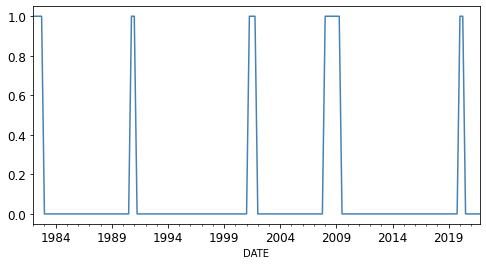

In [31]:
ax = recession.plot(figsize = (8, 4), grid = False, fontsize = 12, color = 'steelblue')
ax.set_facecolor('white')
fig = ax.get_figure()

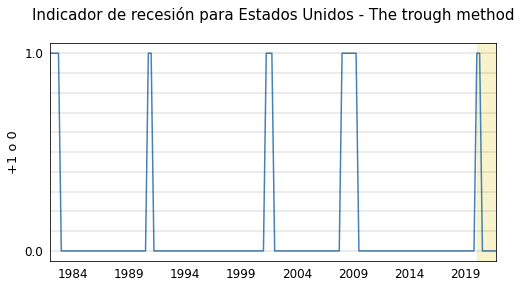

In [32]:
ax.tick_params(left = False, bottom = False, which='both')
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([x if any([x == 0,  x == 1]) else '' for x in ax.get_yticks().round(2)])
ax.set_ylim(-0.05, 1.05)
for y in np.arange(0, 1.1 , 0.1): 
    ax.axhline(y = y, lw = 0.16,  color = 'k', linestyle = '-')
ax.set_title('Indicador de recesión para Estados Unidos - The trough method\n' , fontsize = 15)
ax.axvspan("3/2/2020", end, color='khaki', alpha=0.45)
ax.set_xlabel('')
ax.set_ylabel('+1 o 0', fontsize = 13)
fig

In [12]:
from sklearn.decomposition import PCA

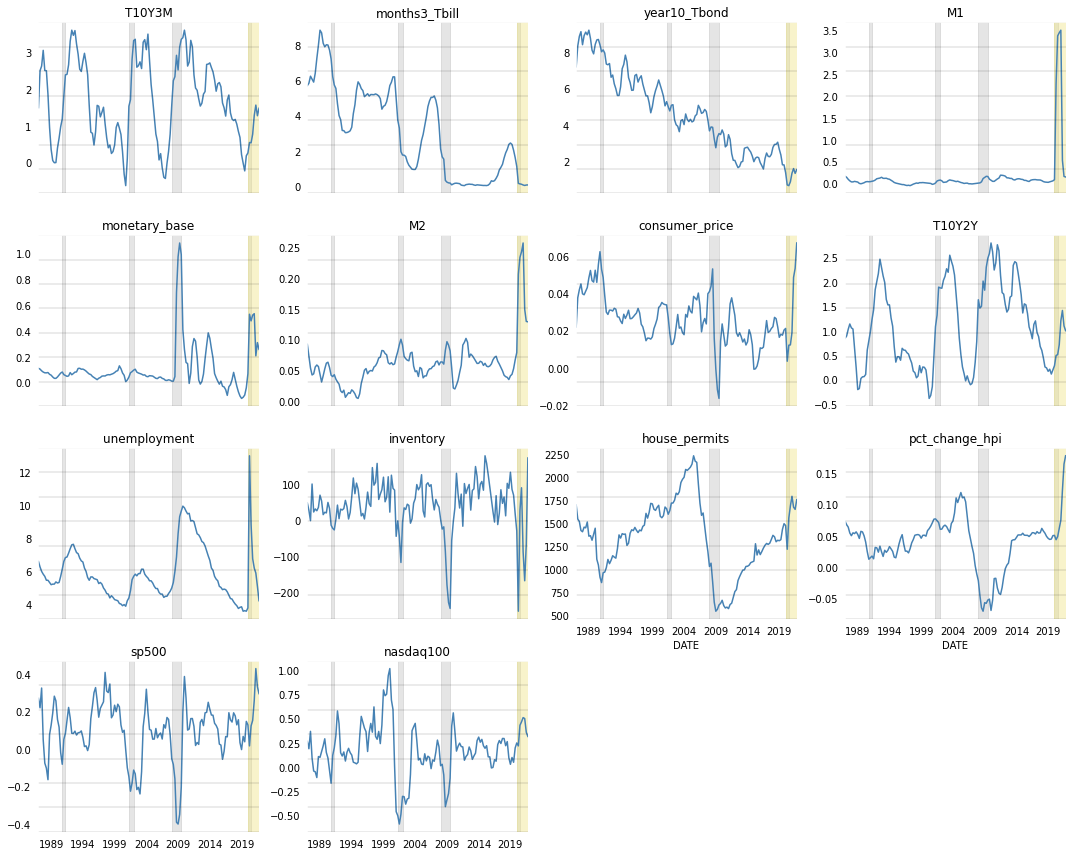

In [35]:
def add_recession_bands(ax):
    for s, e in zip(start_dates, end_dates):
        ax.axvspan(s, e, color="grey", alpha=0.2)

axs = indicators.plot(subplots=True, figsize=(15, 12), layout=(4, 4), legend=False, fontsize = 10, grid = False, color = 'steelblue')

for i, ax in enumerate(axs.flatten()):

    if not set([i]).issubset([14, 15]):
        add_recession_bands(ax)
        ax.set_title(list(indicators)[i], fontsize = 12)
        ax.tick_params(left = False, bottom = False, which='both')
        ax.set_facecolor('white')
        ax.axvspan("3/2/2020", end, color='khaki', alpha=0.45)
        for y in np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 8):
            ax.axhline(y = y , lw = 0.16,  color = 'k', linestyle = '-',)
    spines = ['left', 'right', 'top', 'bottom']
    for spine in spines:
        ax.spines[spine].set_color('white')

for r, c in zip([3]*4, range(0,4)):
    axs[r, c].set_xlabel('', fontsize = 12)

fig = axs[0, 0].get_figure()
fig.tight_layout();

*Variables Macroeconómicas*:

1. Los gráficos nos permiten indicar que en los periodos de recesión se produce caída en el nivel general de los precios, donde la magnitud de la caída de tales se encuentra relacionado directamente con el tiempo de recesión. Ver año 2009.
2. También nos permite señalar que la hubo una incremento abrupto en la base monetaria en el año 2009, ello producto de la recesión y de la política de Quatitative Easy por parte de FED
3. Vemos también que la tasa de desempleo se redujo un poco antes de que se produjera una recesión, por que esta variable puede ser denominada como *leading indicators*.

*Variables Financieras*

1. Tanto S&P 500 index y Nasdaq 100 index han tenido un comportamiento similar, por lo que se escogería por uno de ellos.
2. 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity (T10Y2Y) es un indicador que representa el overview de los inversionistas en cuanto al panorama económico. Podemos ver que este cae previamente a un proceso recesivo, por loq ue también puede ser denominada como *leading indicators*.

*Variables restantes*

1. Tanto los inventarios como las ventas de los minoristas caen en los periodos de recesión.
2. New Privately-Owned Housing Units Authorized in Permit-Issuing Places: Total Units by Month (PERMIT). Se reduce en periodos previos de una recesión y dentro de los periodos de recesión. La magnitud depende de cuan relacionado se encuentre el proceso de recesión con el housing (sector construcción).

In [36]:
indicators = indicators.drop(['M1', 'M2', 'months3_Tbill', 'T10Y3M', 'months3_Tbill', 'year10_Tbond', 'nasdaq100'], axis = 1).copy()

### Modelo

El modelo que vamos a utilizar es *Random Forest*



Un random forest es el promedio de muchos regression trees aleatorizada.

Trees son aleatorizadas por:

- Fitting sobre subconjuntos remuestreados sobre la data
- Aleatorizar las características escogidas por ramas


$$
\min_{j \in S,s} \left[ \min_{c_1} \sum_{i: x_{i,j} \leq s, x_i \in R}
    (y_i - c_1)^2 + \min_{c_2} \sum_{i: x_{i,j} > s, x_i \in R}
    (y_i - c_2)^2 \right]
$$

* Donde $ S $ is a csubconjunto de característica aleatorias.

* Randomizing and averaging suaviza las predicciones relaizadas desde individual trees.

* Esto mejora la predicción .

Lo que se reporta para analizar la relación entre una variable explicativa y la variable explicada es *feature importance*

*Feature importance* es el promedio en el que Gini Index (criterio de information gain) decrece por las desviaciones sobre cada característica.

Si una característica dada tiene una gran importancia, tal característica suele dividir con más frecuencia los trees y además, la divición sobre esa característica resulta en menores disminuciones de Gini Index

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
def make_train_data(indicators, rec, nlead):
    return rec.to_frame().join(indicators.shift(nlead)).dropna()

In [40]:
def fit_for_nlead(ind, rec, nlead, mod):
    
    df = make_train_data(ind, rec, nlead)
    X = df.drop(["recession"], axis=1).copy()
    y = df["recession"].copy()

    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

    mod.fit(X_train, y_train)
    cmat = metrics.confusion_matrix(y_test, mod.predict(X_test), labels = [0, 1])
    feat = mod.feature_importances_
    recall = np.array(metrics.precision_score(y_test, mod.predict(X_test)))
    precision = np.array(metrics.recall_score(y_test, mod.predict(X_test)))
    
    return cmat, feat, recall, precision

In [41]:
# Modelo Default

mod = RandomForestClassifier()

feats = dict()
cmats = dict()
recalls = dict()
precisions = dict()

for nlead in range(0, 5):

    cmats[nlead] = np.zeros((2, 2))
    feats[nlead] = np.zeros(indicators.shape[1])
    recalls[nlead] = np.zeros(1)
    precisions[nlead] = np.zeros(1)
    
    print(f"starting for {nlead} leads")
    for rep in range(100):
        cmat, feat, recall, precision = fit_for_nlead(indicators, recession, nlead, mod)
        cmats[nlead] = cmats[nlead] + cmat
        feats[nlead] = feats[nlead] + feat
        recalls[nlead] = recalls[nlead] + recall
        precisions[nlead] = precisions[nlead] + precision
        
    cmats[nlead] = cmats[nlead] / 100
    feats[nlead] = feats[nlead] / 100
    recalls[nlead] = recalls[nlead] / 100
    precisions[nlead] = precisions[nlead] / 100

starting for 0 leads
starting for 1 leads
starting for 2 leads
starting for 3 leads
starting for 4 leads


In [42]:
for k, v in cmats.items():
    print(f"\n\n El promedio de confusion matrix para {k} lag(s) es :\n {v}")



 El promedio de confusion matrix para 0 lag(s) es :
 [[31.09  0.58]
 [ 2.23  1.1 ]]


 El promedio de confusion matrix para 1 lag(s) es :
 [[31.51  0.26]
 [ 2.4   0.83]]


 El promedio de confusion matrix para 2 lag(s) es :
 [[31.22  0.19]
 [ 3.13  0.46]]


 El promedio de confusion matrix para 3 lag(s) es :
 [[31.51  0.22]
 [ 2.95  0.32]]


 El promedio de confusion matrix para 4 lag(s) es :
 [[30.31  0.33]
 [ 3.03  0.33]]


In [43]:
for k, z in feats.items():
    print(f"\n\n El promedio de Feature importance para {k} lag(s) es:\n ")
    for x, y in zip(indicators.columns, z*100):
        print(f" {x.ljust(15)} {round(y)}%")



 El promedio de Feature importance para 0 lag(s) es:
 
 monetary_base   9%
 consumer_price  10%
 T10Y2Y          6%
 unemployment    8%
 inventory       25%
 house_permits   9%
 pct_change_hpi  13%
 sp500           20%


 El promedio de Feature importance para 1 lag(s) es:
 
 monetary_base   10%
 consumer_price  15%
 T10Y2Y          7%
 unemployment    13%
 inventory       16%
 house_permits   8%
 pct_change_hpi  13%
 sp500           19%


 El promedio de Feature importance para 2 lag(s) es:
 
 monetary_base   15%
 consumer_price  15%
 T10Y2Y          10%
 unemployment    15%
 inventory       9%
 house_permits   9%
 pct_change_hpi  15%
 sp500           13%


 El promedio de Feature importance para 3 lag(s) es:
 
 monetary_base   17%
 consumer_price  17%
 T10Y2Y          14%
 unemployment    15%
 inventory       7%
 house_permits   8%
 pct_change_hpi  13%
 sp500           8%


 El promedio de Feature importance para 4 lag(s) es:
 
 monetary_base   19%
 consumer_price  12%
 T10Y2Y     

In [45]:
for k, v in recalls.items():
    print(f"\n\n El promedio de recall para {k} lag(s) es :\n {round(v[0], 2)}")



 El promedio de recall para 0 lag(s) es :
 0.55


 El promedio de recall para 1 lag(s) es :
 0.53


 El promedio de recall para 2 lag(s) es :
 0.38


 El promedio de recall para 3 lag(s) es :
 0.29


 El promedio de recall para 4 lag(s) es :
 0.28


In [75]:
for k, v in precisions.items():
    print(f"\n\n El promedio de precision para {k} lag(s) es :\n {round(v[0], 3)}")



 El promedio de precision para 0 lag(s) es :
 0.995


 El promedio de precision para 1 lag(s) es :
 0.979


 El promedio de precision para 2 lag(s) es :
 0.98


 El promedio de precision para 3 lag(s) es :
 0.986


 El promedio de precision para 4 lag(s) es :
 0.993


La importancia de una característica en promedio varía de acuerdo a los números de rezagos, vemos que la importancia de las variables 10Y2Y y unemployment en la predicción de la recesión se incrementa a medida que los rezagos se incrementan. De manera inversa ocurre con la variable inventory.

Utilizando el criterio de recall para seleccionar un modelo, el modelo con cero rezagos sería seleccionado, sin embargo, esto se debe a que se ha incorporado variables que se relacionan temporalmente con la recesión. 

Resaltamos que tiene una baja precisión debido a que los datos no están balanceados.

## Neural Networks

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import activations
import numpy as np

In [60]:
def create_model_bin():
    model = Sequential()
    
    model.add(Dense(80, input_dim =8, kernel_initializer='normal', activation=activations.relu))

    model.add(Dense(1, kernel_initializer='normal', activation=activations.sigmoid))

    model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics = ['accuracy'])
    
    return model


In [143]:
def fit_for_nlead(ind, rec, nlead, mod_nn):
    
    df = make_train_data(ind, rec, nlead)
    X = df.drop(["recession"], axis=1).copy()
    y = df["recession"].copy()

    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

    mod.fit(X_train, y_train, epochs=200, batch_size=1, verbose=0)
    
    y_hat_test = np.array(mod_nn.predict(X_test).flatten() >= 0.5, dtype=np.int32)
    y_hat_train = np.array(mod_nn.predict(X_train).flatten() >= 0.5, dtype=np.int32)
    
    cmat = metrics.confusion_matrix(y_test, y_hat_test, labels = [0, 1])
    
    recall_test = np.array(metrics.precision_score(y_test, y_hat_test))
    precision_test = np.array(metrics.recall_score(y_test, y_hat_test))

    recall_train = np.array(metrics.precision_score(y_train, y_hat_train))
    precision_train = np.array(metrics.recall_score(y_train, y_hat_train))
    
    return cmat, recall_train, precision_train, recall_test, precision_test

In [76]:
from collections import namedtuple

mod = create_model_bin()
data_summ = namedtuple('tuple_data', ['cmat', 'recall_train', 'precision_train', 'recall_test', 'precision_test', 'nlead'])

data_list = []
for nlead in range(0, 5):
    
    cmat, recall_train, precision_train, recall_test, precision_test = fit_for_nlead(indicators, recession, nlead, mod)
    data = data_summ(cmat = cmat, recall_train=recall_train, precision_train = precision_train,\
         recall_test =recall_test, precision_test = precision_test, nlead =nlead)
    data_list.append(data)

In [91]:
data_cmat = pd.DataFrame(data_list)
data_cmat = data_cmat.drop(columns=['cmat']).set_index('nlead')
data_cmat = data_cmat.astype(float)
data_cmat.index = data_cmat.index.astype(str) 

<AxesSubplot:xlabel='nlead'>

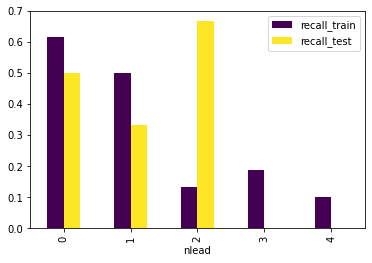

In [103]:
col_chd = data_cmat.columns[data_cmat.columns.str.contains(r'.*recall.*', regex=True)]
data_cmat[col_chd].plot(kind = 'bar', colormap = 'viridis')

<AxesSubplot:xlabel='nlead'>

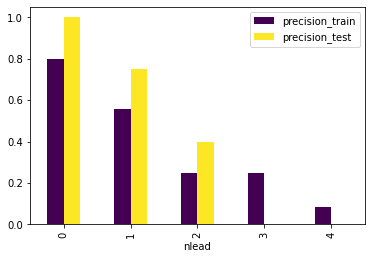

In [104]:
col_chd = data_cmat.columns[data_cmat.columns.str.contains(r'.*pre.*', regex=True)]
data_cmat[col_chd].plot(kind = 'bar', colormap = 'viridis')

In [110]:
cmat = pd.DataFrame(data_list)['cmat']

In [141]:
qs = []
for n, ct in enumerate(cmat):
    cty = ct/ct.sum(axis = 1, keepdims=True)
    ctz = cty.flatten()
    qs.append(ctz)
colums_name = ['P(p_norm|norm)', 'P(p_res|norm)', 'P(p_norm|res)', 'P(p_res|res)']
p_cm = pd.DataFrame(qs, columns=colums_name, index=range(5))    

In [ ]:
p_cm

,P(p_norm|norm),P(p_res|norm),P(p_norm|res),P(p_res|res)
0,0.906250,0.093750,0.00,1.00
1,0.806452,0.193548,0.25,0.75
2,0.966667,0.033333,0.60,0.40
3,0.970588,0.029412,1.00,0.00
4,0.818182,0.181818,1.00,0.00
